In [ ]:
!nvidia-smi

Thu Mar 23 03:56:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    52W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python --version
# !pip install --pre torch torchtext -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
!pip install transformers --quiet
!pip install pytorch-lightning --quiet
# !pip install https://github.com/PyTorchLightning/pytorch-lightning/releases/download/1.2.6/pytorch-lightning-1.2.6.tar.gz  --quiet

Python 3.9.16
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 22.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.functional import auroc, accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import KFold

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

# Data

In [ ]:
!gdown --id 1c7t0jj4b1ORuQnL7hAFet8Vek-Oj00pw

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1c7t0jj4b1ORuQnL7hAFet8Vek-Oj00pw
To: /content/app_reviews.csv
100% 603k/603k [00:00<00:00, 146MB/s]


In [ ]:
df = pd.read_csv("app_reviews.csv")
df.head()

,id,review,class
0,1,"Besides the occasional crash, this is an amazi...",problem discovery
1,2,This could be a great app if it was predictabl...,problem discovery
2,3,I can't open since the last 2 updates Pop-ups ...,problem discovery
3,4,Use to love this app but it's not working afte...,problem discovery
4,5,"Urrrrm\tAfter my third re installing, it final...",problem discovery


In [ ]:
df[df['class'] == "user experience"]

,id,review,class
3084,3085,"Urrrrm\tAfter my third re installing, it final...",user experience
3085,3086,Does exactly what it says on the tin\tEffecien...,user experience
3086,3087,Best of what's available\tI've purchased a few...,user experience
3087,3088,Finally an Office Suite which works great\tI h...,user experience
3088,3089,Pretty good!\tI've edited many photos using th...,user experience
...,...,...,...
3686,3687,Loved this app from jump!\tHave never had any ...,user experience
3687,3688,Best app\tCan always edit my pics and they wil...,user experience
3688,3689,Awesome\tpics art is my only app for editing,user experience
3689,3690,5star!!!!!\tI love it! ! Sumtime hate it catch...,user experience


# Preprocessing

remove info giving class from dataset

In [ ]:
df = df[df['class'] != "information seeking"]

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.25)
train_df.shape, val_df.shape

((3735, 3), (1245, 3))

75 - 25 % split (training size - testing size)

## Distrubution of Labels

Let's look at the distribution of the labels:

[637, 1856, 342, 451, 449]


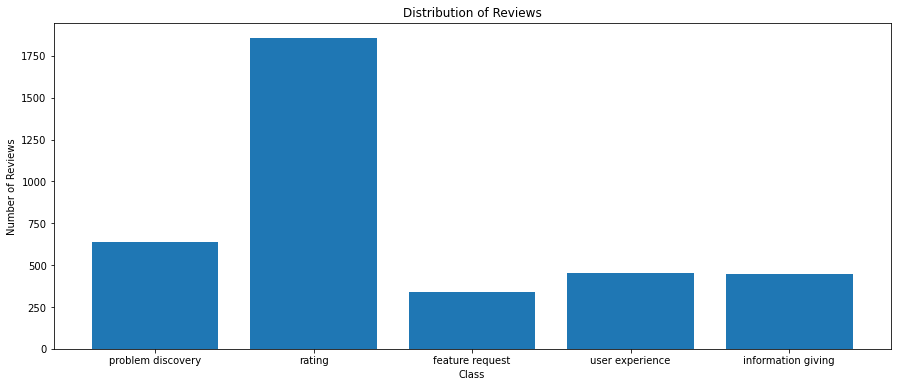

In [ ]:
CLASS_LABELS = df["class"].unique().tolist()
# CLASS_LABELS
fig = plt.figure(figsize=(15, 6))
y = [(train_df['class'] == label).sum() for label in CLASS_LABELS]
print(y)
# ax.bar(CLASS_LABELS, y)
plt.bar(CLASS_LABELS, y)
plt.xlabel("Class")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Reviews")
plt.show()

We have a server imbalance, we carry out undersamppling. To combat this, we'll sample *15,000* examples from the clean comments and create a new training set:

remove information seeking, take sample of all classes of len('feature request') (342 samples)

In [ ]:
pd_train = train_df[train_df['class']=="problem discovery"]
rating_train = train_df[train_df['class']=="rating"]
feature_train = train_df[train_df['class']=="feature request"]
user_experience_train = train_df[train_df['class']=="user experience"]
info_giving_train = train_df[train_df['class']=="information giving"]

no_samples = len(feature_train)
no_samples

342

In [ ]:
train_df = pd.concat([
  pd_train.sample(no_samples),
  rating_train.sample(no_samples),
  feature_train,
  user_experience_train.sample(no_samples),
  info_giving_train.sample(no_samples)
])

train_df.shape, val_df.shape

((1710, 3), (1245, 3))

In [ ]:
train_df

,id,review,class
4344,18550,Can t open pictures to view larger and on the...,problem discovery
302,303,I care more about the functionality than the l...,problem discovery
4126,17579,Please fix this.,problem discovery
4255,18116,Now I can t open links in safari and when I l...,problem discovery
338,339,It seems Evernote did not understand the spiri...,problem discovery
...,...,...,...
4972,15607,It s like a magazine that you get to design y...,information giving
4024,17192,"I m addicted, everyone should have a Pinteres...",information giving
3707,1615,I ve never had any issues with it and have be...,information giving
4660,13501,I love to cook and have many apps and bookmark...,information giving


[342, 342, 342, 342, 342]


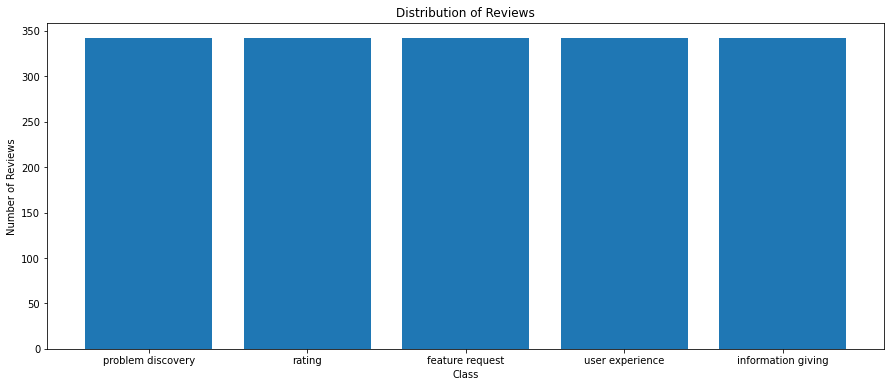

In [ ]:
CLASS_LABELS = df["class"].unique().tolist()
# CLASS_LABELS
fig = plt.figure(figsize=(15, 6))
y = [(train_df['class'] == label).sum() for label in CLASS_LABELS]
print(y)
# ax.bar(CLASS_LABELS, y)
plt.bar(CLASS_LABELS, y)
plt.xlabel("Class")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Reviews")
plt.show()

Now we have an equal representation of samples from each set

## Tokenization
We need to convert the raw text into a list of tokens. For that, we'll use the built-in BertTokenizer:

In [ ]:
BERT_MODEL_NAME = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

We need to specify the maximum number of tokens when encoding (512 is the maximum we can do). Let's check the number of tokens per comment:

In [ ]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["review"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

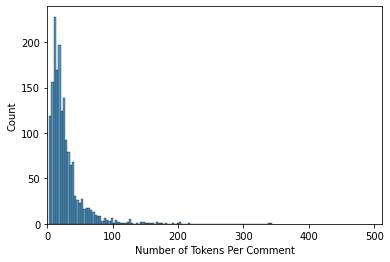

In [ ]:
sns.histplot(token_counts)
plt.xlabel("Number of Tokens Per Comment")
plt.xlim([0, 512]);

Most of the reviews contain less than 200 tokens and a maximum of ~400 Tokens. Therfore, setting the MAX TOKEN COUNT to 512 (default value) will be a waste of storage and processing resourceses.  

In [ ]:
MAX_TOKEN_COUNT = 400

## PyTorch Dataset 

We'll wrap the tokenization process in a PyTorch Dataset, along with converting the labels to tensors:

Before we begin, a single class label need to be converted into a float vector.

In [ ]:
def label_vector(review_label):
  vector = {label:0 for label in CLASS_LABELS}
  vector[review_label]=1
  return list(vector.values())

In [ ]:
class AppReviewDataset(Dataset):
  def __init__(self, data: pd.DataFrame, tokenizer: AutoTokenizer, max_token_len: int=128):
    self.data = data
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)
  
  ## return encoding of review
  def __getitem__ (self, index: int):
    data_row = self.data.iloc[index]
    review = data_row['review']
    label = data_row['class']
    encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )

    return dict(
        review=review,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        labels=torch.FloatTensor(label_vector(label))
    )    

## Load BERT model

In [ ]:
bert_model = AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The larger version of BERT has more attention heads and a larger hidden size.

The final step is to wrap our dataset into a lightningDataModule

In [ ]:
class AppReviewDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.max_token_len = max_token_len

  # create dataset for each of the training and test sets
  def setup(self, stage=None):
    self.train_dataset = AppReviewDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )
    self.test_dataset = AppReviewDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=8
    )
    
  # make predictions on a single example (single batch size)
  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        num_workers=8
    )
  
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        num_workers=8
    )

AppReviewDataModule encapsulates all data loading logic and returns the necessary data loaders. Let’s create an instance of our data module:

# Model

The model will use a pre-trained BertModel and a linear layer to convert the BERT representation to a classification task. This will all be backed in a LightningModule

In [ ]:
from torch.optim import lr_scheduler
class AppReviewTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    # classifier: serve as a way to get the output of the BERT model and convert those into the num of classes which we want to predict
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    # This criterion computes the cross entropy loss between input logits and target
    self.criterion = nn.BCELoss()
    # self.training_step_outputs = []

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    # run linear layer ontop of the output
    output = self.classifier(output.pooler_output)
    # apply sigmoid function
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self.forward(input_ids, attention_mask, labels)
    # self.training_step_outputs.append(outputs)
    # output training loss
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self.forward(input_ids, attention_mask, labels)
    # output training loss
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  
  def test_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self.forward(input_ids, attention_mask, labels)
    # output training loss
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  # def on_train_epoch_end(self):
  #   labels = []
  #   predictions = []
  #   outputs = torch.stack(self.training_step_outputs)
  #   for output in outputs:
  #     for out_labels in output['labels'].detach().cpu():
  #       labels.append(out_labels)

  #     for out_predictions in output['predictions'].detach().cpu():
  #       predictions.append(out_predictions)

  #   # convert to tourch
  #   labels = torch.stack(labels).int()
  #   predictions = torch.stack(predictions)

  #   # Calculate ROC score for each tag
  #   for i, name in enumerate(CLASS_LABELS):
  #     class_roc_auc = auroc(predictions[:, i], labels[:, i])
  #     self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
    
  #   self.training_step_outputs.clear()  # free memory

  # configer optimisers and learning rate scheduler
  def configure_optimizers(self):
    # fine tuning recomendations from original BERT paper
    optimizer = AdamW(self.parameters(), lr=2e-5)
  
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=self.n_warmup_steps,
        num_training_steps=self.n_training_steps
    )

    # return a list of optimisers and schedulers
    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
        )
    )

Most of the implementation is just a boilerplate. Two points of interest are the wat the optimizer is configured and calculating the area under ROC. We'll dive a bit deep into those next.

##Using an optimiser

We simulate 100 training steps and tell the scheduler to warm up for the first 20. The learning rate grows to the initial fixed value of 0.001 during the warm-up and then goes down (linearly) to 0.

To use the scheduler, we need to calculate the number of training and warm-up steps. The number of training steps per epoch is equal to number of training examples / batch size. The number of total training steps is training steps per epoch * number of epochs:

# Training

The beauty of PyTorch Lightning is that you can build a standard pipeline and train every model you might imagine. I prefer to use at least 3 components.

Checkpointing that saves the best model (based on validation loss):


Log the progress in TensorBoard:



And early stopping triggers when the loss hasn’t improved for the last 2 epochs (you might want to remove/reconsider this when training on real-world projects):

# Train with K-fold Cross Validation

In [ ]:
# split dataset into k-folds
df

,id,review,class
0,1,"Besides the occasional crash, this is an amazi...",problem discovery
1,2,This could be a great app if it was predictabl...,problem discovery
2,3,I can't open since the last 2 updates Pop-ups ...,problem discovery
3,4,Use to love this app but it's not working afte...,problem discovery
4,5,"Urrrrm\tAfter my third re installing, it final...",problem discovery
...,...,...,...
5075,143450,Bakwas application\tAlways not responding prob...,problem discovery
5076,143476,Ma fav\tI just love it,information giving
5077,143509,But the problem is very slow running to update.,problem discovery
5078,143513,But I d suggest two important features which ...,feature request


[342, 342, 342, 342, 342]


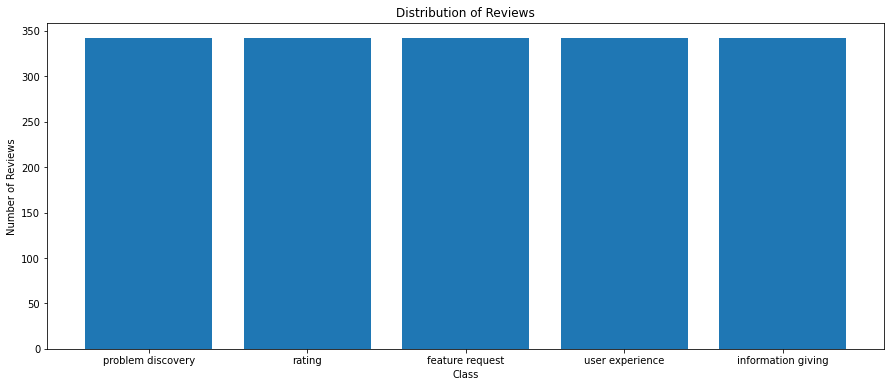

In [ ]:
CLASS_LABELS = df["class"].unique().tolist()
# CLASS_LABELS
fig = plt.figure(figsize=(15, 6))
y = [(train_df['class'] == label).sum() for label in CLASS_LABELS]
print(y)
# ax.bar(CLASS_LABELS, y)
plt.bar(CLASS_LABELS, y)
plt.xlabel("Class")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Reviews")
plt.show()



---



#DistilBert-base-uncase

In [ ]:
BERT_MODEL_NAME = 'distilbert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertModel: ['distilbert.transformer.layer.5.attention.k_lin.weight', 'distilbert.transformer.layer.4.attention.k_lin.weight', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.3.attention.k_lin.bias', 'distilbert.transformer.layer.2.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin2.weight', 'distilbert.transformer.layer.3.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.embe

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 8
MAX_TOKEN_COUNT = 400
THRESHOLD = 0.5
BERT_MODEL_NAME = 'distilbert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

accuracies = []
AUROC_evalute = []

kFold = KFold(n_splits=5, shuffle=True)
for fold_number, (train_index, test_index) in enumerate(kFold.split(df)):
  train_df = df.iloc[train_index]
  val_df = df.iloc[test_index]

  data_module = AppReviewDataModule(
      train_df,
      val_df,
      tokenizer,
      batch_size=BATCH_SIZE,
      max_token_len=MAX_TOKEN_COUNT
  )

  steps_per_epoch = len(train_df) // BATCH_SIZE
  total_training_steps = steps_per_epoch * N_EPOCHS
  warmup_steps = total_training_steps // 5

  model = AppReviewTagger(
    n_classes=len(CLASS_LABELS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
  )
  
  checkpoint_callback = ModelCheckpoint(
    dirpath="distilbert/Fold-{0}".format(fold_number),
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
  )
  logger = TensorBoardLogger("lightning_logs", name="app-comments")
  early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

  trainer = pl.Trainer(
    logger=logger,
    callbacks=[early_stopping_callback, checkpoint_callback],
    max_epochs=N_EPOCHS
    # gpus=1,
    # progress_bar_refresh_rate=30
  )

  trainer.fit(model, data_module)
  trainer.test(model, data_module)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # trained_model = model.to(device)

  val_dataset = AppReviewDataset(
    val_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
  )

  predictions = []
  labels = []

  with torch.no_grad(): 
    for item in tqdm(val_dataset):
      input_ids = item["input_ids"].unsqueeze(dim=0)
      attention_mask = item["attention_mask"].unsqueeze(dim=0)
      input_ids.to(device)
      attention_mask.to(device)
      _, prediction = model(
        input_ids,
        attention_mask
      )
      predictions.append(prediction.flatten())
      labels.append(item["labels"].int())

    predictions = torch.stack(predictions).detach().cpu()
    labels = torch.stack(labels).detach().cpu()

    # store accuracy of each fold
    fold_accuracy = accuracy(task="multilabel", num_labels=len(CLASS_LABELS), preds=predictions, target=labels, threshold=THRESHOLD)
    print("fold-{0}: accuracy: {1}".format(fold_number, fold_accuracy))
    accuracies.append(fold_accuracy)
    # store auroc of each fold
    roc = {}
    print("AUROC per tag")
    for i, name in enumerate(CLASS_LABELS):
      tag_auroc = auroc(predictions[:, i], labels[:, i], task="binary")
      print(f"{name}: {tag_auroc}")
      roc[name] = tag_auroc
      AUROC_evalute.append(roc)
  

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertModel: ['distilbert.transformer.layer.5.attention.k_lin.weight', 'distilbert.transformer.layer.4.attention.k_lin.weight', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.3.attention.k_lin.bias', 'distilbert.transformer.layer.2.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin2.weight', 'distilbert.transformer.layer.3.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.embe

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 498: 'val_loss' reached 0.36750 (best 0.36750), saving model to '/content/distilbert/Fold-0/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 996: 'val_loss' reached 0.31080 (best 0.31080), saving model to '/content/distilbert/Fold-0/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1494: 'val_loss' reached 0.28144 (best 0.28144), saving model to '/content/distilbert/Fold-0/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1992: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2490: 'val_loss' reached 0.26126 (best 0.26126), saving model to '/content/distilbert/Fold-0/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2988: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 3486: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2964372932910919
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


  0%|          | 0/996 [00:00<?, ?it/s]

fold-0: accuracy: 0.8594377636909485
AUROC per tag
problem discovery: 0.9172521829605103
rating: 0.9050967693328857
feature request: 0.8799759149551392
user experience: 0.8286292552947998
information giving: 0.9251165390014648


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertModel: ['distilbert.transformer.layer.5.attention.k_lin.weight', 'distilbert.transformer.layer.4.attention.k_lin.weight', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.3.attention.k_lin.bias', 'distilbert.transformer.layer.2.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin2.weight', 'distilbert.transformer.layer.3.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.1.sa_layer_norm.weight', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.5.output_layer_norm.bias', 'distilbert.transformer.l

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 498: 'val_loss' reached 0.38542 (best 0.38542), saving model to '/content/distilbert/Fold-1/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 996: 'val_loss' reached 0.34215 (best 0.34215), saving model to '/content/distilbert/Fold-1/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1494: 'val_loss' reached 0.29160 (best 0.29160), saving model to '/content/distilbert/Fold-1/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1992: 'val_loss' reached 0.29090 (best 0.29090), saving model to '/content/distilbert/Fold-1/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2490: 'val_loss' reached 0.28364 (best 0.28364), saving model to '/content/distilbert/Fold-1/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2988: 'val_loss' reached 0.27889 (best 0.27889), saving model to '/content/distilbert/Fold-1/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 3486: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 3984: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3257114887237549
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


  0%|          | 0/996 [00:00<?, ?it/s]

fold-1: accuracy: 0.8724899888038635
AUROC per tag
problem discovery: 0.9148262739181519
rating: 0.8838291168212891
feature request: 0.8951700329780579
user experience: 0.7938512563705444
information giving: 0.9208245277404785


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertModel: ['distilbert.transformer.layer.5.attention.k_lin.weight', 'distilbert.transformer.layer.4.attention.k_lin.weight', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.3.attention.k_lin.bias', 'distilbert.transformer.layer.2.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin2.weight', 'distilbert.transformer.layer.3.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.1.sa_layer_norm.weight', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.5.output_layer_norm.bias', 'distilbert.transformer.l

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 498: 'val_loss' reached 0.41194 (best 0.41194), saving model to '/content/distilbert/Fold-2/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 996: 'val_loss' reached 0.33534 (best 0.33534), saving model to '/content/distilbert/Fold-2/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1494: 'val_loss' reached 0.29025 (best 0.29025), saving model to '/content/distilbert/Fold-2/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1992: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2490: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.29557281732559204
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


  0%|          | 0/996 [00:00<?, ?it/s]

fold-2: accuracy: 0.8761044144630432
AUROC per tag
problem discovery: 0.9055303335189819
rating: 0.9001390933990479
feature request: 0.8231539726257324
user experience: 0.8317760825157166
information giving: 0.9221676588058472


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertModel: ['distilbert.transformer.layer.5.attention.k_lin.weight', 'distilbert.transformer.layer.4.attention.k_lin.weight', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.3.attention.k_lin.bias', 'distilbert.transformer.layer.2.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin2.weight', 'distilbert.transformer.layer.3.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.1.sa_layer_norm.weight', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.5.output_layer_norm.bias', 'distilbert.transformer.l

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 498: 'val_loss' reached 0.38931 (best 0.38931), saving model to '/content/distilbert/Fold-3/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 996: 'val_loss' reached 0.38212 (best 0.38212), saving model to '/content/distilbert/Fold-3/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1494: 'val_loss' reached 0.32670 (best 0.32670), saving model to '/content/distilbert/Fold-3/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1992: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2490: 'val_loss' reached 0.31469 (best 0.31469), saving model to '/content/distilbert/Fold-3/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2988: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 3486: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.331707626581192
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


  0%|          | 0/996 [00:00<?, ?it/s]

fold-3: accuracy: 0.8582329154014587
AUROC per tag
problem discovery: 0.9138402938842773
rating: 0.8707141876220703
feature request: 0.855889618396759
user experience: 0.8074969053268433
information giving: 0.8958245515823364


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertModel: ['distilbert.transformer.layer.5.attention.k_lin.weight', 'distilbert.transformer.layer.4.attention.k_lin.weight', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.3.attention.k_lin.bias', 'distilbert.transformer.layer.2.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin2.weight', 'distilbert.transformer.layer.3.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.1.sa_layer_norm.weight', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.5.output_layer_norm.bias', 'distilbert.transformer.l

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 498: 'val_loss' reached 0.39965 (best 0.39965), saving model to '/content/distilbert/Fold-4/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 996: 'val_loss' reached 0.32852 (best 0.32852), saving model to '/content/distilbert/Fold-4/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1494: 'val_loss' reached 0.32316 (best 0.32316), saving model to '/content/distilbert/Fold-4/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1992: 'val_loss' reached 0.29182 (best 0.29182), saving model to '/content/distilbert/Fold-4/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2490: 'val_loss' reached 0.27565 (best 0.27565), saving model to '/content/distilbert/Fold-4/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2988: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 3486: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2930091321468353
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


  0%|          | 0/996 [00:00<?, ?it/s]

fold-4: accuracy: 0.8797188997268677
AUROC per tag
problem discovery: 0.9166465997695923
rating: 0.9003791213035583
feature request: 0.9017348289489746
user experience: 0.8427796363830566
information giving: 0.91570645570755


In [ ]:
accuracies, AUROC_evalute

([tensor(0.8594),
  tensor(0.8725),
  tensor(0.8761),
  tensor(0.8582),
  tensor(0.8797)],
 [{'problem discovery': tensor(0.9173),
   'rating': tensor(0.9051),
   'feature request': tensor(0.8800),
   'user experience': tensor(0.8286),
   'information giving': tensor(0.9251)},
  {'problem discovery': tensor(0.9173),
   'rating': tensor(0.9051),
   'feature request': tensor(0.8800),
   'user experience': tensor(0.8286),
   'information giving': tensor(0.9251)},
  {'problem discovery': tensor(0.9173),
   'rating': tensor(0.9051),
   'feature request': tensor(0.8800),
   'user experience': tensor(0.8286),
   'information giving': tensor(0.9251)},
  {'problem discovery': tensor(0.9173),
   'rating': tensor(0.9051),
   'feature request': tensor(0.8800),
   'user experience': tensor(0.8286),
   'information giving': tensor(0.9251)},
  {'problem discovery': tensor(0.9173),
   'rating': tensor(0.9051),
   'feature request': tensor(0.8800),
   'user experience': tensor(0.8286),
   'information 

In [ ]:
accuracies = np.array(accuracies)
np.mean(accuracies)

0.8691968

In [ ]:
AUROC_evalute[4]

{'problem discovery': tensor(0.9173),
 'rating': tensor(0.9051),
 'feature request': tensor(0.8800),
 'user experience': tensor(0.8286),
 'information giving': tensor(0.9251)}

The average accuracy across all 5 Folds is 0.87. The fold which produced the highest accuracy was Fold 2.

In [ ]:
trained_model = AppReviewTagger.load_from_checkpoint(
  "./distilbert/Fold-4/best-checkpoint.ckpt",
  n_classes=len(CLASS_LABELS)
)
trained_model.eval()
trained_model.freeze()

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertModel: ['distilbert.transformer.layer.5.attention.k_lin.weight', 'distilbert.transformer.layer.4.attention.k_lin.weight', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.3.attention.k_lin.bias', 'distilbert.transformer.layer.2.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin2.weight', 'distilbert.transformer.layer.3.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.1.sa_layer_norm.weight', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.5.output_layer_norm.bias', 'distilbert.transformer.l

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = AppReviewDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

with torch.no_grad(): 
  for item in tqdm(val_dataset):
    input_ids = item["input_ids"].unsqueeze(dim=0)
    attention_mask = item["attention_mask"].unsqueeze(dim=0)
    input_ids.to(device)
    attention_mask.to(device)
    _, prediction = model(
      input_ids,
      attention_mask
    )
    predictions.append(prediction.flatten())
    labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/996 [00:00<?, ?it/s]

In [ ]:
accuracy(task="multilabel", num_labels=len(CLASS_LABELS), preds=predictions, target=labels, threshold=THRESHOLD)

tensor(0.8783)

In [ ]:
print("AUROC per tag")
for i, name in enumerate(CLASS_LABELS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], task="binary")
  print(f"{name}: {tag_auroc}")

AUROC per tag
problem discovery: 0.9158735275268555
rating: 0.9042308926582336
feature request: 0.8966645002365112
user experience: 0.8408036231994629
information giving: 0.9150745272636414


In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true,
  y_pred,
  target_names=CLASS_LABELS,
  zero_division=0
))

                    precision    recall  f1-score   support

 problem discovery       0.65      0.70      0.67       165
            rating       0.74      0.92      0.82       490
   feature request       0.63      0.25      0.36        95
   user experience       0.53      0.08      0.14       129
information giving       0.73      0.49      0.58       117

         micro avg       0.71      0.66      0.68       996
         macro avg       0.66      0.49      0.51       996
      weighted avg       0.69      0.66      0.63       996
       samples avg       0.65      0.66      0.66       996



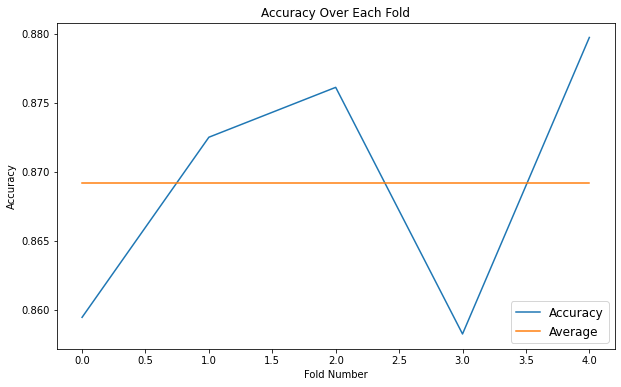

In [ ]:
x_axis = np.arange(5)
y_axis = accuracies
average_y = [np.mean(y_axis)for i in range(5)]

fig = plt.figure(figsize=(10, 6))
plt.plot(x_axis, y_axis, label='Accuracy')
plt.plot(x_axis, average_y, label='Average')
plt.title('Accuracy Over Each Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.legend(loc="lower right", prop={'size': 12})

plt.show()

[tensor(0.9173), tensor(0.9051), tensor(0.8800), tensor(0.8286), tensor(0.9251)]


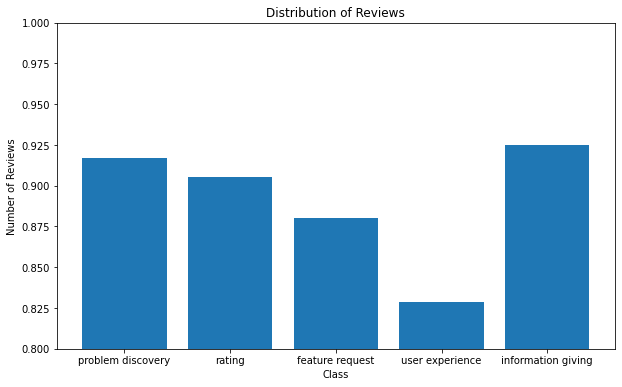

In [ ]:
CLASS_LABELS = df["class"].unique().tolist()
# CLASS_LABELS

# AUROC_evalute

for i, label in enumerate(CLASS_LABELS):
  fig = plt.figure(figsize=(10, 6))
  y = [AUROC_evalute[2][label] for label in CLASS_LABELS]
  print(y)
  # ax.bar(CLASS_LABELS, y)
  plt.bar(CLASS_LABELS, y)
  plt.ylim(0.8, 1)
  plt.xlabel("Class")
  plt.ylabel("Number of Reviews")
  plt.title("Distribution of Reviews")
  plt.show()
  break